<a href="https://colab.research.google.com/github/SVGS-EVA4/Phase2/blob/master/S7-Variational_AutoEncoders/Extras/Shilpa/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code taken from https://vxlabs.com/2017/12/08/variational-autoencoder-in-pytorch-commented-and-annotated/

In [1]:
!pip install torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp '/content/drive/My Drive/E4P2/cars_dataset/cars_dataset.zip' '/content'

In [1]:
# example from https://github.com/pytorch/examples/blob/master/vae/main.py
# commented and type annotated by Charl Botha <cpbotha@vxlabs.com>

import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# changed configuration to this instead of argparse for easier interaction
CUDA = True
SEED = 1
BATCH_SIZE = 128
LOG_INTERVAL = 10
EPOCHS = 500
IMAGE_DIM = (96, 96, 3)
capacity = 64
latent_dims = 40

# connections through the autoencoder bottleneck
# in the pytorch VAE example, this is 20
ZDIMS = 20

# # I do this so that the MNIST dataset is downloaded where I want it
# os.chdir("/home/cpbotha/Downloads/pytorch-vae")

In [3]:
from zipfile import ZipFile 
if 'cars_dataset' in os.listdir('/content'):
  print('Dataset already unzipped')
else:
  with ZipFile('/content/cars_dataset.zip', 'r') as zip_file: 
    print('Unzipping dataset')
    zip_file.extractall() 
    print('Done!')

Dataset already unzipped


In [4]:
from torch.utils.data import Dataset
import random
import glob
from PIL import Image

def CarsDataset(data_path='',train_transform=None,test_transform=None,split=70):
  fpaths = sorted(glob.glob(os.path.join(data_path, '*.jpg')))
  random.shuffle(fpaths)
  train_len = len(fpaths)*split//100
  train = CARS( file_paths= fpaths[:train_len], transform=train_transform)
  test = CARS( file_paths= fpaths[train_len:], transform=test_transform)
  return train,test

class CARS(Dataset):

    def __init__(self, file_paths, transform=None):

        self.transform = transform
        self.fpaths = file_paths

    def __getitem__(self, idx):
        img = self.transform(Image.open(self.fpaths[idx]))
        return img

    def __len__(self):
        return len(self.fpaths)

In [5]:
transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                               ]
)


In [6]:
train_set,test_set = CarsDataset(data_path='/content/cars_dataset/', train_transform=transform,test_transform=transform)

In [7]:
def load(train_set,test_set,seed=1,batch_size=128,num_workers=4,pin_memory=True):
	
	SEED = 1

	# CUDA?
	cuda = torch.cuda.is_available()


	# For reproducibility
	torch.manual_seed(SEED)

	if cuda:
			torch.cuda.manual_seed(SEED)

	# dataloader arguments - something you'll fetch these from cmdprmt
	dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory) if cuda else dict(shuffle=True, batch_size=64)

	trainloader = torch.utils.data.DataLoader(train_set, **dataloader_args)
	testloader = torch.utils.data.DataLoader(test_set, **dataloader_args)


	return  trainloader, testloader

In [8]:
train_loader,test_loader = load(train_set,test_set,batch_size=BATCH_SIZE)

shape: torch.Size([128, 3, 96, 96])


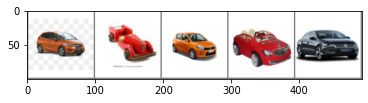

In [9]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def show_random_images(dataset):

	# get some random training images
	dataiter = iter(dataset)
	images = dataiter.next()

	img_list = range(5, 10)

	# show images
	print('shape:', images.shape)
	imshow(torchvision.utils.make_grid(images[img_list]))
   
show_random_images(train_loader)

In [10]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # ENCODER
        
        c = capacity
        self.convE1 = nn.Sequential(
          
            nn.Conv2d(in_channels=3, out_channels=c, kernel_size=4, stride=2, padding=1), # out: c x 48 x 48
            nn.ReLU(),                     
            nn.BatchNorm2d(c),
            nn.Conv2d(in_channels=c, out_channels=c, kernel_size=4, stride=2, padding=1), # out: c x 24 x 24
            nn.ReLU(),                     
            nn.BatchNorm2d(c),
            nn.Conv2d(in_channels=c, out_channels=c, kernel_size=4, stride=2, padding=1), # out: c x 12 x 12
            nn.ReLU(),                     
            nn.BatchNorm2d(c),
            nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1), # out: c x 6 x 6
            
        )
        self.fcE11 = nn.Linear(in_features=c*2*6*6, out_features=latent_dims)
        self.fcE12 = nn.Linear(in_features=c*2*6*6, out_features=latent_dims)
     
        

        # DECODER
        self.convD1 = nn.Sequential(
          
            nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1), # out: c x 48 x 48
            nn.ReLU(),                     
            nn.BatchNorm2d(c),
            nn.ConvTranspose2d(in_channels=c, out_channels=c, kernel_size=4, stride=2, padding=1), # out: c x 24 x 24
            nn.ReLU(),                     
            nn.BatchNorm2d(c),
            nn.ConvTranspose2d(in_channels=c, out_channels=c, kernel_size=4, stride=2, padding=1), # out: c x 12 x 12
            nn.ReLU(),                     
            nn.BatchNorm2d(c),
            nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=4, stride=2, padding=1), # out: c x 6 x 6
            
        )
        self.fcD11 = nn.Linear(in_features=latent_dims, out_features=c*2*6*6)
       
        self.sigmoid = nn.Sigmoid()

    def encode(self, x: Variable) -> (Variable, Variable):

        x = self.convE1(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        return self.fcE11(x), self.fcE12(x)

    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:
        """THE REPARAMETERIZATION IDEA:

        For each training sample (we get 128 batched at a time)

        - take the current learned mu, stddev for each of the ZDIMS
          dimensions and draw a random sample from that distribution
        - the whole network is trained so that these randomly drawn
          samples decode to output that looks like the input
        - which will mean that the std, mu will be learned
          *distributions* that correctly encode the inputs
        - due to the additional KLD term (see loss_function() below)
          the distribution will tend to unit Gaussians

        Parameters
        ----------
        mu : [128, ZDIMS] mean matrix
        logvar : [128, ZDIMS] variance matrix

        Returns
        -------

        During training random sample from the learned ZDIMS-dimensional
        normal distribution; during inference its mean.

        """

        if self.training:
            # multiply log variance with 0.5, then in-place exponent
            # yielding the standard deviation
            std = logvar.mul(0.5).exp_()  # type: Variable
            # - std.data is the [128,ZDIMS] tensor that is wrapped by std
            # - so eps is [128,ZDIMS] with all elements drawn from a mean 0
            #   and stddev 1 normal distribution that is 128 samples
            #   of random ZDIMS-float vectors
            eps = Variable(std.data.new(std.size()).normal_())
            # - sample from a normal distribution with standard
            #   deviation = std and mean = mu by multiplying mean 0
            #   stddev 1 sample with desired std and mu, see
            #   https://stats.stackexchange.com/a/16338
            # - so we have 128 sets (the batch) of random ZDIMS-float
            #   vectors sampled from normal distribution with learned
            #   std and mu for the current input
            return eps.mul(std).add_(mu)

        else:
            # During inference, we simply spit out the mean of the
            # learned distribution for the current input.  We could
            # use a random sample from the distribution, but mu of
            # course has the highest probability.
            return mu

    def decode(self, x: Variable) -> Variable:

        x = self.fcD11(x)
        x = x.view(x.size(0), capacity*2, 6, 6) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = self.sigmoid(self.convD1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [11]:
model = VAE()
if CUDA:
    model.cuda()

In [12]:
summary(model, input_size=(3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,136
              ReLU-2           [-1, 64, 48, 48]               0
       BatchNorm2d-3           [-1, 64, 48, 48]             128
            Conv2d-4           [-1, 64, 24, 24]          65,600
              ReLU-5           [-1, 64, 24, 24]               0
       BatchNorm2d-6           [-1, 64, 24, 24]             128
            Conv2d-7           [-1, 64, 12, 12]          65,600
              ReLU-8           [-1, 64, 12, 12]               0
       BatchNorm2d-9           [-1, 64, 12, 12]             128
           Conv2d-10            [-1, 128, 6, 6]         131,200
           Linear-11                   [-1, 40]         184,360
           Linear-12                   [-1, 40]         184,360
           Linear-13                 [-1, 4608]         188,928
  ConvTranspose2d-14           [-1, 64,

In [13]:
def loss_function(recon_x, x, mu, logvar) -> Variable:
    # how well do input x and output recon_x agree?
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KLD is Kullback–Leibler divergence -- how much does one learned
    # distribution deviate from another, in this specific case the
    # learned distribution from the unit Gaussian

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
  
    KLD /= BATCH_SIZE
    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    return BCE + KLD

In [14]:
# Dr Diederik Kingma: as if VAEs weren't enough, he also gave us Adam!
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [15]:
div_factor = 25
def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
   
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 96, 96]
    pbar = tqdm(train_loader)
    for batch_idx, data in enumerate(pbar):
        data = Variable(data)
        # print('sshape---',data.shape)
        if CUDA:
            data = data.cuda()
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)
        # calculate scalar loss
        loss = loss_function(recon_batch, data, mu, logvar)
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables -- by the power of pytorch!
        # print('loss----------',loss)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        pbar.set_description(desc= f'Epoch {epoch} Train Loss: {loss.item() / len(data)} Batch_id={batch_idx}' )
    return train_loss / len(train_loader.dataset)
    

def test(epoch):
    # toggle model to test / inference mode
    model.eval()
    test_loss = 0

    # each data is of BATCH_SIZE (default 128) samples
    pbar = tqdm(test_loader)
    for i, data in enumerate(pbar):
        if CUDA:
            # make sure this lives on the GPU
            data = data.cuda()

        # we're only going to infer, so no autograd at all required: volatile=True
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
       
        test_loss += loss_function(recon_batch, data, mu, logvar).item()
        if epoch % div_factor==0:
          if i == 0:
            n = min(data.size(0), 8)
            # for the first 128 batch of the epoch, show the first 8 input digits
            # with right below them the reconstructed output digits
            comparison = torch.cat([data[:n],
                                    recon_batch.view(BATCH_SIZE, 3, IMAGE_DIM[0], IMAGE_DIM[1])[:n]])
            save_image(comparison.data.cpu(),
                      'results/reconstruction_' + str(epoch) + '.png', nrow=n)
        pbar.set_description(desc= f' Test Loss: {test_loss} Batch_id={i}' )
    test_loss /= len(test_loader.dataset)
    
    return test_loss




In [18]:
if 'results' not in os.listdir('/content'):
  os.mkdir('results')

In [19]:
train_loss = []
test_loss = []
for epoch in range(1, EPOCHS + 1):
    trainl = train(epoch)
    testl = test(epoch)

    train_loss.append(trainl)
    test_loss.append(testl)
    # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
    # digits in latent space
    if epoch % div_factor==0: 
      sample = Variable(torch.randn(64, latent_dims))
      if CUDA:
          sample = sample.cuda()
      sample = model.decode(sample).cpu()

      # save out as an 8x8 matrix of MNIST digits
      # this will give you a visual idea of how well latent space can generate things
      # that look like digits
      save_image(sample.data.view(64, 3, IMAGE_DIM[0], IMAGE_DIM[1]),
                'results/sample_' + str(epoch) + '.png')

 Test Loss: 2671958.84375 Batch_id=1: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]
Epoch 3 Train Loss: -1352.0673295454546 Batch_id=2: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]
 Test Loss: 2433233.8125 Batch_id=1: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]
Epoch 4 Train Loss: -2668.5355113636365 Batch_id=2: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]
 Test Loss: 1996033.3125 Batch_id=1: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]
Epoch 5 Train Loss: -8955.142045454546 Batch_id=2: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]
 Test Loss: 2023120.40625 Batch_id=1: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]
Epoch 6 Train Loss: -13044.503409090908 Batch_id=2: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]
 Test Loss: 577609.859375 Batch_id=1: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]
Epoch 7 Train Loss: -14653.470454545455 Batch_id=2: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]
 Test Loss: -833791.125 Batch_id=1: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]
Epoch 8 Tra

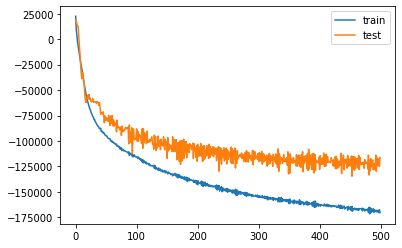

In [20]:
plt.plot(train_loss,label='train')
plt.plot(test_loss,label='test')
plt.legend()

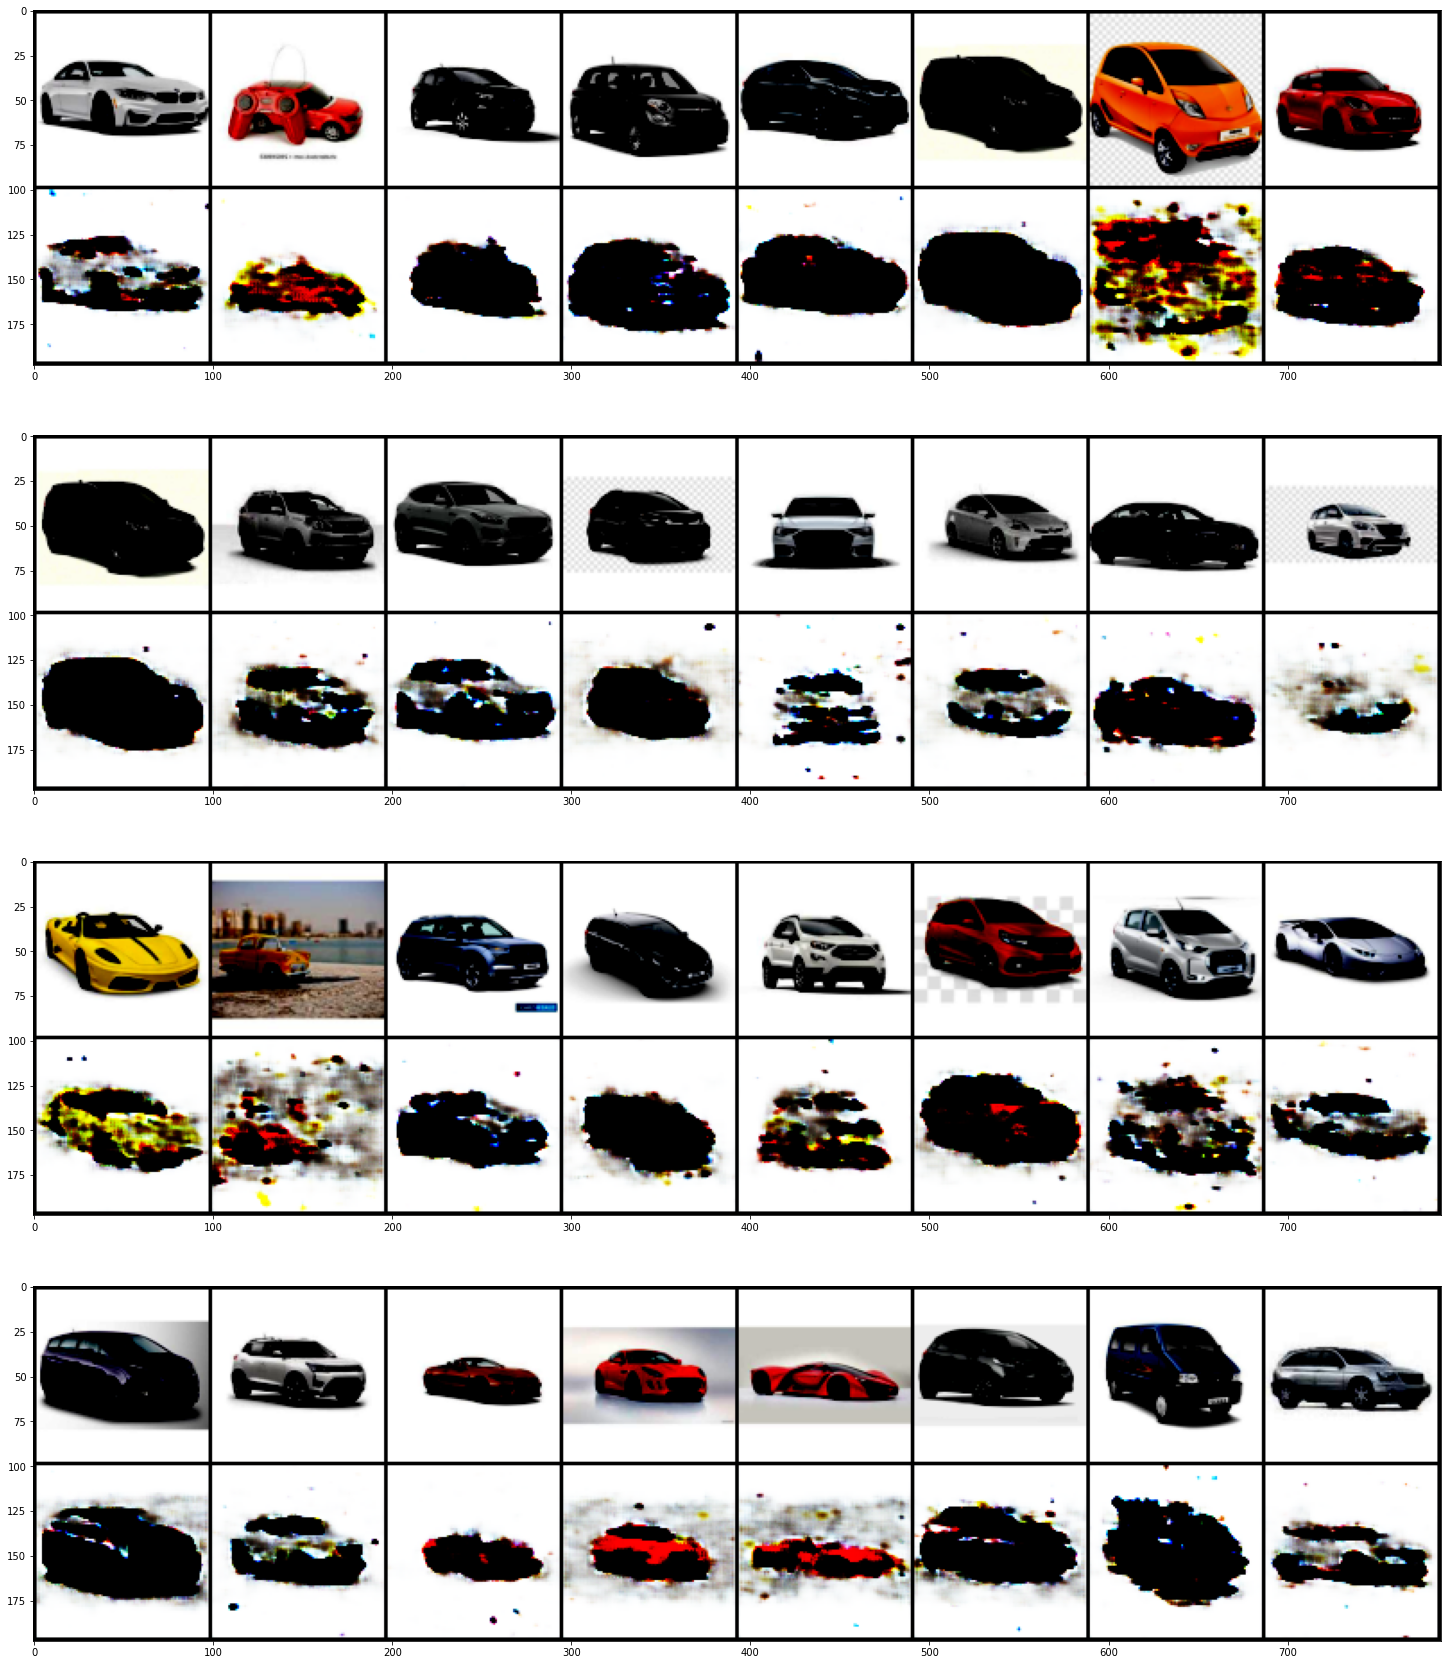

In [26]:
fig, ax = plt.subplots(4,1,figsize=(30,30))

ax[0].imshow(Image.open('/content/results/reconstruction_400.png'))
ax[1].imshow(Image.open('/content/results/reconstruction_450.png'))
ax[2].imshow(Image.open('/content/results/reconstruction_475.png'))
ax[3].imshow(Image.open('/content/results/reconstruction_500.png'))